In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg

# Eigenvalues/Eigenvectors

Vectors acted on by a transformation tend to rotate.  Here's an example.

In [2]:
A=np.zeros((2,2))
A[0,0]=1.
A[0,1]=2.
A[1,0]=2.
A[1,1]=5.
x0=np.array([1,0])
x1=A.dot(x0)

(-0.1, 2.5)

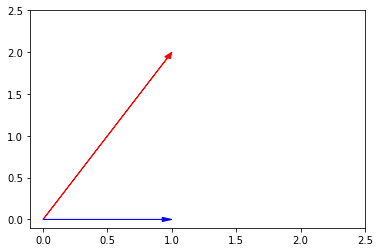

In [3]:
origin = np.array([0., 0.])
plt.arrow(origin[0], origin[1], x0[0], x0[1], head_width=0.05, color='blue',length_includes_head=True)
plt.arrow(origin[0], origin[1], x1[0], x1[1], head_width=0.05, color='red',length_includes_head=True)
plt.xlim((-0.1, 2.5))
plt.ylim((-0.1, 2.5))

However, transforming an eigenvector doesn't change its direction, only its length.

In [4]:
w,v=linalg.eig(A)
print(w)
print(v)

[0.17157288 5.82842712]
[[-0.92387953 -0.38268343]
 [ 0.38268343 -0.92387953]]


In [5]:
y0=v[:,0]
z0=v[:,1]
y1=A.dot(y0)
z1=A.dot(z0)

(-5.5, 1.0)

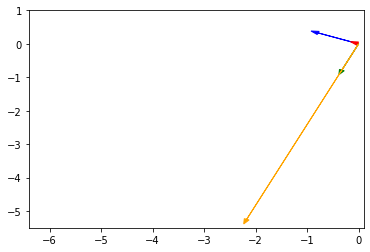

In [6]:
plt.arrow(origin[0], origin[1], y0[0], y0[1], head_width=0.1, color='blue',length_includes_head=True)
plt.arrow(origin[0], origin[1], y1[0], y1[1], head_width=0.1, color='red',length_includes_head=True)
plt.arrow(origin[0], origin[1], z0[0], z0[1], head_width=0.1, color='green',length_includes_head=True)
plt.arrow(origin[0], origin[1], z1[0], z1[1], head_width=0.1, color='orange',length_includes_head=True)
plt.xlim((-6.4,0.1))
plt.ylim((-5.5,1))

The matrix of right eigenvectors is given in the matrix $\mathbf{V}$.  The left eigenvectors are $\mathbf{V}^T$, with $\mathbf{V}$ being orthogonal.

In [7]:
np.dot(v,v.T)

array([[ 1.00000000e+00, -2.58605321e-17],
       [-2.58605321e-17,  1.00000000e+00]])

This symmetric matrix is positive-definite, which we know because all the eigenvaues are positive.  Many matrices in physics and statistics are positive-definite, including the moment of inertia, the Hamiltonian, and the covariance matrix.

Note that for nonsymmetric matrices, such as the rotation matrix, the eigenvalues and eigenvectors can be complex.

In [8]:
R=np.array([[1.,-1.],[1.,1.]])/np.sqrt(2.)# 45 deg rotation matrix
w,v=linalg.eig(R)
print(w)
print(v)

[0.70710678+0.70710678j 0.70710678-0.70710678j]
[[0.70710678+0.j         0.70710678-0.j        ]
 [0.        -0.70710678j 0.        +0.70710678j]]


It's more illuminating in exponential form.  The eigenvalues are $e^{\pm i\pi/4}$ and the eigenvectors are $(1,\mp i)/\sqrt{2}$ .

# QR Decomposition

Numpy's eigenvector codes use QR decomposition, where $\mathbf{Q}$ is an orthogonal matrix and $\mathbf{R}$ is an upper triangular matrix.  Numpy has a routine to do a QR decomposition of a matrix, *numpy.linalg.qr*. 

In [9]:
B=np.random.random((5,5))
B=(B+B.T)/2 # symmetrize matrix

Text(0.5, 1.0, 'B')

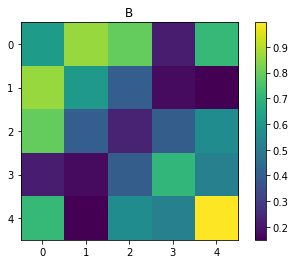

In [10]:
plt.imshow(B)
plt.colorbar()
plt.title('B')

In [11]:
Q,R=np.linalg.qr(B)
QQT=np.dot(Q,Q.T)
print(B-np.dot(Q,R))

[[-2.22044605e-16 -5.55111512e-16 -5.55111512e-16 -2.22044605e-16
  -6.66133815e-16]
 [ 0.00000000e+00 -1.11022302e-16  5.55111512e-17 -5.55111512e-17
   2.77555756e-17]
 [-1.11022302e-16 -2.22044605e-16 -1.11022302e-16  0.00000000e+00
  -2.22044605e-16]
 [ 0.00000000e+00 -2.77555756e-17  0.00000000e+00  0.00000000e+00
  -1.11022302e-16]
 [ 0.00000000e+00 -2.77555756e-17  1.11022302e-16  0.00000000e+00
  -3.33066907e-16]]


Text(0.5, 1.0, '$QQ^T$')

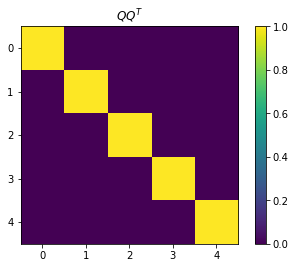

In [12]:
plt.imshow(QQT)
plt.colorbar()
plt.title('$QQ^T$')

Text(0.5, 1.0, 'R')

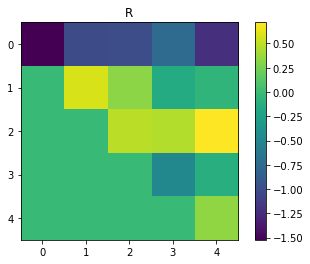

In [13]:
plt.imshow(R)
plt.colorbar()
plt.title('R')

Here we show that performing the similarity transformation $\mathbf{B}\to\mathbf{Q}^{\rm T}\mathbf{B}\mathbf{Q}$, where $\mathbf{Q}$ comes from successive QR decompositions of $\mathbf{B}$, reduces the off-diagonal entries while the determinants are unchanged.

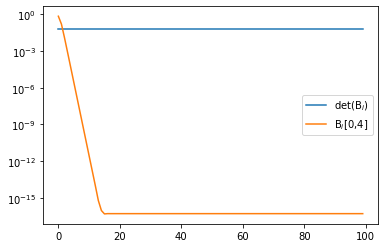

In [14]:
st=np.zeros((5,5))
st[:]=B[:]
ntrans = 100
detB=np.zeros(ntrans)
detB[0]=np.linalg.det(st)
offd=np.zeros(ntrans)
offd[0]=abs(st[0,-1])

for i in np.arange(1,ntrans):
    Q1,R1=np.linalg.qr(st)
    st=np.dot(Q1.T,np.dot(st,Q1))
    detB[i]=np.linalg.det(st)
    offd[i]=abs(st[0,-1])

plt.plot(np.round(detB,8),label='det(B${}_i$)')
plt.semilogy(offd,label='B${}_i$[0,4]')
plt.legend()

Now we show a code that computes the eigenvectors using QR decomposition. Note in my code I construct a tolerance test where I make a copy of my matrix, set its diagonal to zero, and find the largest off-diagonal element in matrix, such that I end the calculation when the largest off-diagonal element is less than the tolerance.

In [15]:
def qreigen(A,tol=1.e-10):
    n=len(A[:,0])
    testD=np.zeros((n,n))
    D=np.zeros((n,n))
    X=np.identity(n)
    D[:,:]=A[:,:] # initialize the diagonal matrix
    testD[:,:]=D[:,:] # create tolerance test matrix
    for i in np.arange(n):
        testD[i,i]=0.
    test=np.max(abs(testD)) # tolerance test
    while (test>=tol):
        Q,R=np.linalg.qr(D)
        D=np.dot(Q.T,np.dot(D,Q)) # compute next D
        X=np.dot(X,Q) # compute next vector matrix
        testD[:,:]=D[:,:]
        for i in np.arange(n):
            testD[i,i]=0.
        test=np.max(abs(testD)) # new tolerance test
    D=np.diag(D)
    ind=np.argsort(D) # sort eigenvalues in increasing order
    D=D[ind]
    X=X[:,ind]
    return D,X

In [16]:
D,X=qreigen(B)
print(D)
print(X)

[-0.52617745 -0.16299798  0.3705301   0.84013321  2.63386876]
[[ 0.72468848  0.19808357 -0.14520262  0.33713108  0.54849644]
 [-0.36838545 -0.51852754  0.29692862  0.59993506  0.38383938]
 [-0.53275422  0.73358664  0.00846112  0.03368798  0.42049626]
 [ 0.16724012 -0.04822779  0.76778876 -0.52544155  0.32267077]
 [-0.16529504 -0.38912313 -0.54879726 -0.4991962   0.52046658]]


We show here that our result is consistent with numpy's subroutine.

In [17]:
Dt,Xt=np.linalg.eigh(B) # compute difference from numpy routine
print(Dt/D-1)
print(np.abs(Xt/X)-1.) # use abs because some vectors could point in opposite direction

[ 1.55431223e-15 -1.88737914e-15 -4.21884749e-15 -4.77395901e-15
 -2.22044605e-16]
[[-1.65029101e-11 -9.99200722e-16  4.04068112e-10  1.29807276e-12
  -1.77635684e-15]
 [-6.42703668e-11 -1.33226763e-15  1.00442321e-10 -3.73034936e-13
  -1.11022302e-15]
 [-1.24600330e-12 -1.11022302e-16  5.09771181e-09 -9.56512647e-12
  -6.66133815e-16]
 [ 3.73588493e-10  2.88657986e-15 -1.76371140e-11 -1.95288230e-13
   4.44089210e-16]
 [ 2.66975109e-10 -4.44089210e-16 -2.43873810e-11  1.99396055e-13
  -6.66133815e-16]]


# Spring Problem

In lecture we derived that the solution for the wave equation for a "springy" string $$-\rho(x)\frac{\partial^2u}{\partial t^2}+\frac{\partial}{\partial x}\left[p(x)\frac{\partial u}{\partial x}\right]-q(x)u(x,t)=0$$ can be written using separation of variables as $$u(x,t)=\sum_kw_k(x)v_k(t)\, .$$ In this case, $$v_k(t)=a_k\cos(\omega_kt)+b_k\sin(\omega_kt)$$ and the differential equation for $w(x)$ can be converted using the finite-difference method into the eigenvalue problem $\mathbf{M}\cdot\mathbf{w}=\omega^2\mathbf{w}$, where over the 1D grid $x_i=ih,\,\{i=1,N\}$, $\mathbf{w}=\{w(x_1),w(x_2),...,w(x_N)\}$.  Defining $Z_i=Z(x_i)$ for quantities $\rho(x)$, $q(x)$, and $p(x)$, the matrix $\mathbf{M}$ is given by $$\mathbf{M}=\frac{1}{h^2}\left(\begin{array}{cccccc}\frac{p_{1/2}+p_{3/2}+h^2q_1}{\rho_1}&\frac{-p_{3/2}}{\rho_1}&0&...&...&0\\\frac{-p_{3/2}}{\rho_2}&\frac{p_{3/2}+p_{5/2}+h^2q_2}{\rho_2}&\frac{-p_{5/2}}{\rho_2}&0&...&0\\0&\frac{-p_{5/2}}{\rho_3}&\frac{p_{5/2}+p_{7/2}+h^2q_3}{\rho_3}&\frac{-p_{7/2}}{\rho_3}&0&...\\...&...&...&...&...&...\\0&0&0&0&\frac{-p_{N-1/2}}{\rho_N}&\frac{p_{N-1/2}+p_{N+1/2}+h^2q_N}{\rho_N}\end{array}\right)\, .$$  In this section we will solve this to get the eigenvalues $\omega_k^2$ and the eigenvectors $\mathbf{w}_k$ for various physical cases.

First we start with the case where there is no springiness, $q=0$, and both $p$ and $\rho$ are constants such that $p/\rho=c^2$, where $c=1$ m/s. The string is 1 m long and we will use 200 subdivisions in the string, which means 199 points within the string.

In [18]:
from matplotlib import animation
from IPython.display import HTML

In [19]:
N=199
h=1./(N+1)
c2=1.
M=np.zeros((N,N))
M[0,0]=2*c2
M[0,1]=-c2
M[-1,-2]=-c2
M[-1,-1]=2*c2
for i in np.arange(1,N-1):
    M[i,i-1]=-c2
    M[i,i]=2*c2
    M[i,i+1]=-c2
M/=h**2
om2,w=linalg.eig(M)
isort = np.argsort(om2)
om2=om2[isort]
w=w[:,isort]

Here are the first 30 $\omega$ values.

In [20]:
om=np.sqrt(om2)
print(om[:30])

[ 3.14156036  6.28292692  9.42390593 12.56430363 15.7039263  18.84258028
 21.98007196 25.11620781 28.25079437 31.38363829 34.51454632 37.64332533
 40.76978232 43.89372444 47.01495898 50.13329343 53.24853541 56.36049278
 59.46897356 62.57378602 65.67473863 68.77164011 71.86429944 74.95252583
 78.03612881 81.11491814 84.18870393 87.25729656 90.32050675 93.37814554]


Here we plot the first 3 $\mathbf{w}$ vectors.

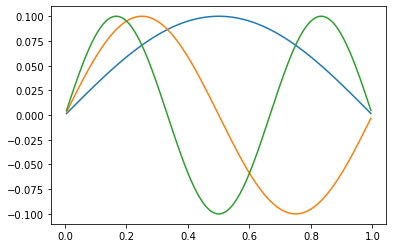

In [21]:
x=np.arange(1,N+1)*h
for i in np.arange(3):
    plt.plot(x,w[:,i])

At $t=0$, we can set the $a_k$ coefficients using $$u(x,t=0)=\sum_ka_kw_k(x)\,.$$  Although in this case, $\mathbf{M}$ is symmetric and the $\mathbf{w}$ vectors are thus orthogonal, in the general case $\mathbf{M}$ is not symmetric.  In that case you could multiply $u(x,t=0)$ by the inverse of the eigenvector matrix.

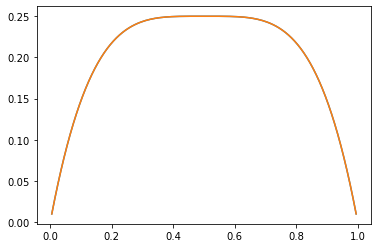

In [22]:
initial = (- (x - 0.5)**4 + 0.5**4) * 4.
winv=linalg.inv(w)
ak=winv.dot(initial)
plt.plot(x,initial)
plt.plot(x,w.dot(ak))

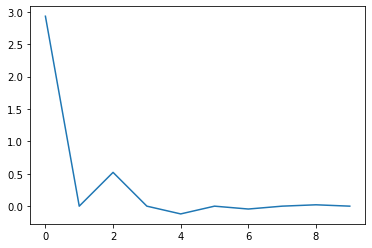

In [23]:
plt.plot(ak[:10])

We will assume that the spring starts at rest, which requires $b_k=0$.  Now we have enough to construct the motion of the string.  This code makes an animated line plot.  Note that to make it run on your computer you need to install *ffmpeg*, which can be done at the command line with *conda install ffmpeg*.

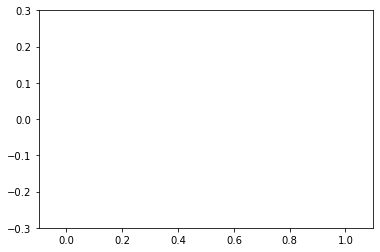

In [24]:
fig, ax = plt.subplots()

ax.set_xlim(( -0.1, 1.1))
ax.set_ylim((- 0.3, 0.3))

line, = ax.plot([], [], lw=2)

nframes = 500

def init():
    line.set_data([], [])
    return (line,)

In [25]:
def frame(i):
        period =  2. * np.pi / om[0]
        t = np.float64(i) / np.float64(nframes) * period * 4
        coeffs = ak * np.cos(om * t)
        y = w.dot(coeffs).flatten()
        line.set_data(x, y)
        return (line,)

In [26]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, frame, init_func=init,
                               frames=nframes, interval=40, blit=True,
                               repeat_delay=2000)

HTML(anim.to_html5_video())

For a springy string, vibrations are a bit different.

In [27]:
q=40.
M[0,0]=2*c2+h**2*q
M[0,1]=-c2
M[-1,-2]=-c2
M[-1,-1]=2*c2+h**2*q
for i in np.arange(1,N-1):
    M[i,i-1]=-c2
    M[i,i]=2*c2+h**2*q
    M[i,i+1]=-c2
M/=h**2
om2,w=linalg.eig(M)
isort = np.argsort(om2)
om2=om2[isort]
w=w[:,isort]

In [28]:
om=np.sqrt(om2)
print(om[:30])

[ 7.06182706  8.91488479 11.34944946 14.06633306 16.92965745 19.87568443
 22.87189462 25.90026824 28.95008433 32.01457094 35.0892278  38.17093058
 41.2574254  44.34702972 47.43844821 50.53065515 53.62281719 56.71424112
 59.80433777 62.89259651 65.97856693 69.06184535 72.14206494 75.21888811
 78.29200086 81.36110831 84.42593126 87.4862035  90.54166963 93.59208335]


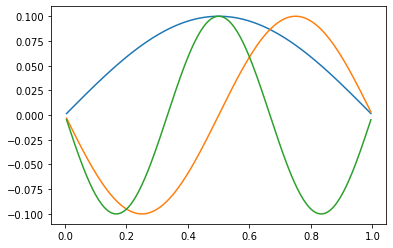

In [29]:
x=np.arange(1,N+1)*h
for i in np.arange(3):
    plt.plot(x,w[:,i])

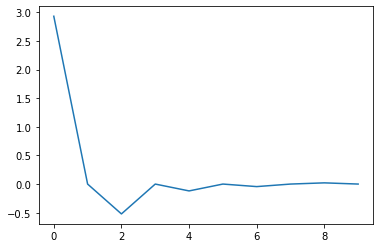

In [30]:
winv=linalg.inv(w)
ak=winv.dot(initial)
plt.plot(ak[:10])

In [31]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, frame, init_func=init,
                               frames=nframes, interval=40, blit=True,
                               repeat_delay=2000)

HTML(anim.to_html5_video())